Midterm Regression Model:

In [13]:
#All columns (Lifestyle and Social Media)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    accuracy_score,
    classification_report
)

RANDOM_STATE = 42

# Replace with your real path if different
df = pd.read_csv(r"C:\Users\dorot\Downloads\social_media_vs_productivity.csv")

# Optional quick cleaning of empty strings to NaN
df = df.replace({"": np.nan, "NA": np.nan, "na": np.nan, "N/A": np.nan})

# Make sure boolean like columns are real booleans
for c in ["uses_focus_apps", "has_digital_wellbeing_enabled"]:
    if c in df.columns:
        df[c] = df[c].map(
            {True: True, False: False, "True": True, "False": False, 1: True, 0: False}
        ).astype("boolean")

# Coerce numeric targets and some key numeric columns
for c in [
    "actual_productivity_score",
    "perceived_productivity_score",
    "daily_social_media_time",
    "work_hours_per_day",
    "sleep_hours",
    "number_of_notifications",
    "coffee_consumption_per_day",
    "screen_time_before_sleep",
    "job_satisfaction_score",
    "weekly_offline_hours",
    "days_feeling_burnout_per_month",
    "breaks_during_work"
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Light capping to reduce extreme noise
cap_rules = {
    "sleep_hours": (0, 16),
    "daily_social_media_time": (0, 16),
    "work_hours_per_day": (0, 16),
    "number_of_notifications": (0, 300),
    "coffee_consumption_per_day": (0, 15),
}
for c, (lo, hi) in cap_rules.items():
    if c in df.columns:
        df[c] = df[c].clip(lower=lo, upper=hi)

# =========================
# 1. Drop rows with missing regression target
# =========================
n0 = len(df)
df = df.dropna(subset=["actual_productivity_score"]).copy()
print(f"Dropped {n0 - len(df)} rows with missing actual_productivity_score")

# =========================
# 2. Define features and targets
# =========================
# Regression target
y_reg = df["actual_productivity_score"]
X_reg = df.drop(columns=["actual_productivity_score"])

# Classification label: low productivity if actual score < 5
df["low_prod"] = (y_reg < 5).astype(int)
y_clf = df["low_prod"]
X_clf = X_reg.copy()

# Identify feature types
num_cols = X_reg.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_reg.select_dtypes(include=["object", "category", "boolean"]).columns.tolist()

# =========================
# 3. Preprocessing
# =========================
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# handle scikit versions
try:
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    # older scikit versions use 'sparse' not 'sparse_output'
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# =========================
# 4. Linear Regression
# =========================
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

linreg = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train_r, y_train_r)
y_pred_r = linreg.predict(X_test_r)

r2 = r2_score(y_test_r, y_pred_r)
rmse = mean_squared_error(y_test_r, y_pred_r) ** 0.5

print("\n=== Linear Regression on test set ===")
print(f"R2:   {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

Dropped 2365 rows with missing actual_productivity_score

=== Linear Regression on test set ===
R2:   0.906
RMSE: 0.583


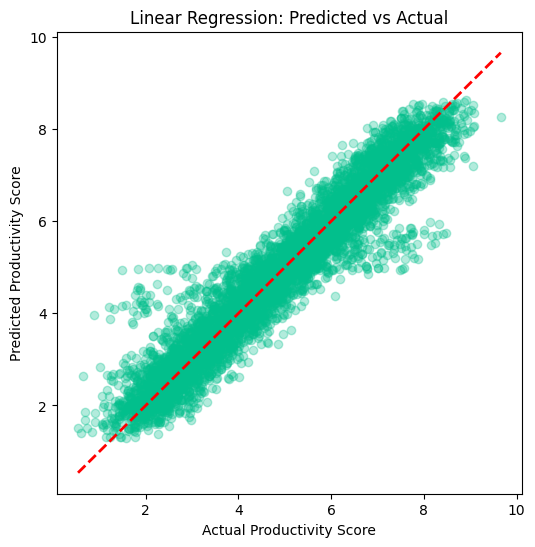

In [14]:
# Regression graph all points
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6,6))
plt.scatter(y_test_r, y_pred_r, alpha=0.3, color = "#02bf8c")
plt.plot(
    [y_test_r.min(), y_test_r.max()],
    [y_test_r.min(), y_test_r.max()],
    "r--", lw=2
)

plt.xlabel("Actual Productivity Score")
plt.ylabel("Predicted Productivity Score")
plt.title("Linear Regression: Predicted vs Actual")
plt.show()

In [15]:
#Just the social mediua columns
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------
#  NEW: Social Media Only Regression Model
# -------------------------------------------
social_media_cols = [
    "daily_social_media_time",
    "number_of_notifications",
    "screen_time_before_sleep",
    "uses_focus_apps",
    "has_digital_wellbeing_enabled",
    "weekly_offline_hours"
]

# Filter out only the chosen columns
X_social = df[social_media_cols].copy()
y_social = df["actual_productivity_score"]

# Split data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_social, y_social, test_size=0.2, random_state=RANDOM_STATE
)

# Identify numeric vs categorical for this subset
num_cols_s = X_social.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_s = X_social.select_dtypes(include=["object", "category", "boolean"]).columns.tolist()

# Preprocessing
num_pipe_s = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    cat_pipe_s = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    cat_pipe_s = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocessor_s = ColumnTransformer([
    ("num", num_pipe_s, num_cols_s),
    ("cat", cat_pipe_s, cat_cols_s)
])

# Model
social_linreg = Pipeline([
    ("prep", preprocessor_s),
    ("model", LinearRegression())
])

# Train & predict
social_linreg.fit(X_train_s, y_train_s)
y_pred_s = social_linreg.predict(X_test_s)

# Metrics
r2_s = r2_score(y_test_s, y_pred_s)
rmse_s = mean_squared_error(y_test_s, y_pred_s) ** 0.5

print("\n=== Social Media Only Linear Regression ===")
print(f"R2:   {r2_s:.3f}")
print(f"RMSE: {rmse_s:.3f}")


=== Social Media Only Linear Regression ===
R2:   -0.000
RMSE: 1.898


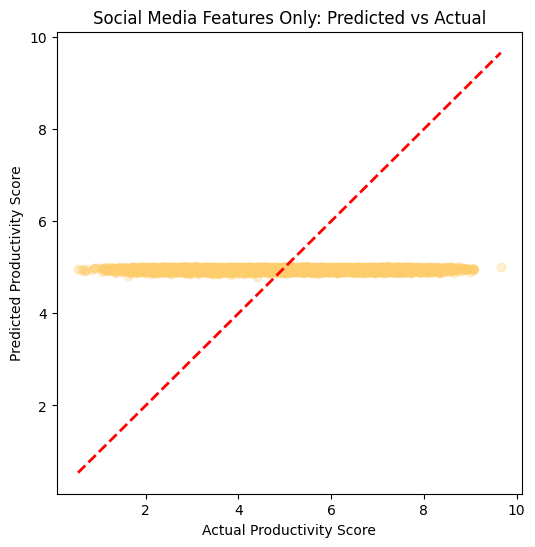

In [16]:
#Regression graph just social media
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6,6))
plt.scatter(y_test_s, y_pred_s, alpha=0.3, color="#fecd6b")
plt.plot([y_test_s.min(), y_test_s.max()], [y_test_s.min(), y_test_s.max()], "r--", lw=2)
plt.xlabel("Actual Productivity Score")
plt.ylabel("Predicted Productivity Score")
plt.title("Social Media Features Only: Predicted vs Actual")
plt.show()

In [19]:
#Just the lifestyle columns
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------
#  NEW: lifestyle Only Regression Model
# -------------------------------------------
lifestyle_cols = [
    "sleep_hours",
    "stress_level",
    "coffee_consumption_per_day",
    "days_feeling_burnout_per_month",
    "breaks_during_work",
    "weekly_offline_hours",
    "job_satisfaction_score",
    "work_hours_per_day"
]

# Filter out only the chosen columns
X_social = df[lifestyle_cols].copy()
y_social = df["actual_productivity_score"]

# Split data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_social, y_social, test_size=0.2, random_state=RANDOM_STATE
)

# Identify numeric vs categorical for this subset
num_cols_s = X_social.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_s = X_social.select_dtypes(include=["object", "category", "boolean"]).columns.tolist()

# Preprocessing
num_pipe_s = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    cat_pipe_s = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    cat_pipe_s = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocessor_s = ColumnTransformer([
    ("num", num_pipe_s, num_cols_s),
    ("cat", cat_pipe_s, cat_cols_s)
])

# Model
social_linreg = Pipeline([
    ("prep", preprocessor_s),
    ("model", LinearRegression())
])

# Train & predict
social_linreg.fit(X_train_s, y_train_s)
y_pred_s = social_linreg.predict(X_test_s)

# Metrics
r2_s = r2_score(y_test_s, y_pred_s)
rmse_s = mean_squared_error(y_test_s, y_pred_s) ** 0.5

print("\n=== Social Media Only Linear Regression ===")
print(f"R2:   {r2_s:.3f}")
print(f"RMSE: {rmse_s:.3f}")


=== Social Media Only Linear Regression ===
R2:   0.711
RMSE: 1.021


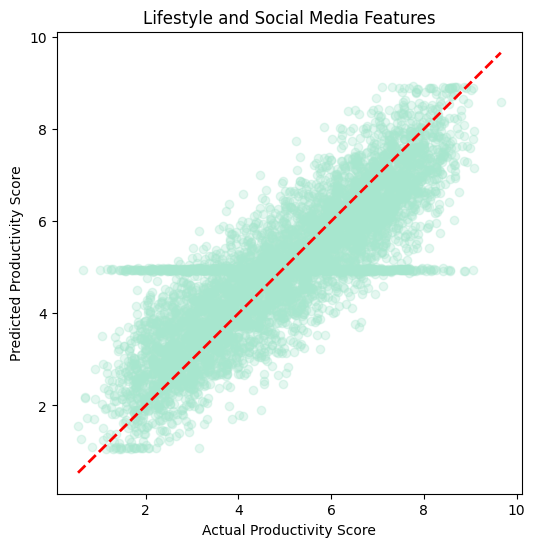

In [18]:
#Regression graph just lifestyle habits
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6,6))
plt.scatter(y_test_s, y_pred_s, alpha=0.3, color="#a7e6ce")
plt.plot([y_test_s.min(), y_test_s.max()], [y_test_s.min(), y_test_s.max()], "r--", lw=2)
plt.xlabel("Actual Productivity Score")
plt.ylabel("Predicted Productivity Score")
plt.title("Lifestyle and Social Media Features")
plt.show()